In [5]:
import random
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import mlflow
import mlflow.pytorch

from datasets import DatasetA, DatasetB, cfg
from datasets.base import collate_bb
from datasets.augmentation import augment_batch
from train.metrics import get_metrics, compute_map50
from train.plotting import plot_predictions

mlflow.set_tracking_uri("file:///media/sdb1/mlflow")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS   = 40
BATCH_SIZE   = 4
NUM_WORKERS  = 4
LR           = 0.005
WEIGHT_DECAY = 1e-4

VAL_FRAC_A   = 0.1
VAL_FRAC_B   = 0.1

PRINT_EVERY  = 50
EXPERIMENT_NAME = "maskrcnn_karyo"

NUM_CLASSES = cfg.num_classes  # background + 24


def make_model():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, NUM_CLASSES)
    return model

#datasets
ds_a_full = DatasetA(cfg.root_a_xml, cfg.root_a_img, cfg.label_map, cfg.max_size, num_channels = 3)
ds_b_full = DatasetB(cfg.root_b, "train", cfg.label_map, cfg.max_size, num_channels = 3)
n_val_a = max(1, int(len(ds_a_full) * VAL_FRAC_A))
n_val_b = max(1, int(len(ds_b_full) * VAL_FRAC_B))
g_ = torch.Generator().manual_seed(42)
ds_a_train, ds_a_val = random_split(ds_a_full,[len(ds_a_full) - n_val_a, n_val_a],generator=g_)
ds_b_train, ds_b_val = random_split(ds_b_full,[len(ds_b_full) - n_val_b, n_val_b],generator=g_)
ds_b_test = DatasetB(cfg.root_b, "test", cfg.label_map, cfg.max_size, num_channels = 3)


def make_loaders_B():
    train_loader = DataLoader(ds_b_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate_bb)
    val_loader = DataLoader(ds_b_val,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_bb,)
    return train_loader, val_loader

def make_loaders_AplusB():
    train_ds = ConcatDataset([ds_a_train, ds_b_train])
    train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate_bb)
    val_loader = DataLoader(ds_b_val,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_bb)
    return train_loader, val_loader

def make_loader_A_val():
    return DataLoader(ds_a_val,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS, collate_fn=collate_bb)

def make_loader_B_test():
    return DataLoader(ds_b_test,batch_size=1,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate_bb)

def to_device(images, targets):
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets

def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0

    for step, (images, targets) in enumerate(loader, 1):
        images, targets = augment_batch(images, targets)
        images, targets = to_device(images, targets)

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if step % PRINT_EVERY == 0 or step == len(loader):
            print(
                f"[epoch {epoch + 1:03d}/{NUM_EPOCHS:03d}] "
                f"step {step}/{len(loader)}  "
                f"loss {loss.item():.4f}"
            )

    return running_loss / len(loader)


def eval_one_epoch(model, loader):
    model.train() #ahh wee return losses?
    running_loss = 0.0

    with torch.no_grad():
        for images, targets in loader:
            images, targets = to_device(images, targets)
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            running_loss += loss.item()

    return running_loss / len(loader)


def run_training(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, experiment_name=EXPERIMENT_NAME):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)

    history = {"train_loss": [], "val_loss": []}

    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        mlflow.log_params({
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "weight_decay": WEIGHT_DECAY,
            "num_epochs": num_epochs,
        })

        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, epoch)
            val_loss = eval_one_epoch(model, val_loader)

            print(
                f"epoch {epoch + 1:03d}/{num_epochs:03d}  "
                f"train={train_loss:.4f}  val={val_loss:.4f}"
            )

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)

        mlflow.pytorch.log_model(model, "model")

    return history


def eval_B_test_metrics(model):
    import numpy as np

    loader = make_loader_B_test()
    preds, targs = [], []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for out, gt in zip(outputs, targets):
                out = {k: v.cpu() for k, v in out.items()}
                gt = {k: v.cpu() for k, v in gt.items()}

                # boxes / scores / labels as tensors
                pred = {
                    "boxes": out["boxes"],
                    "scores": out["scores"],
                    "labels": out["labels"],
                }
                targ = {
                    "boxes": gt["boxes"],
                    "labels": gt["labels"],
                }

                if "masks" in out:
                    m = out["masks"]
                    if m.ndim == 4:       # [N,1,H,W] -> [N,H,W]
                        m = m[:, 0]
                    pred["masks"] = (m > 0.5).byte().numpy()

                if "masks" in gt:
                    targ["masks"] = gt["masks"].numpy().astype(np.uint8)

                preds.append(pred)
                targs.append(targ)

    metrics = get_metrics(preds, targs, num_classes=NUM_CLASSES - 1)
    return metrics


def eval_A_val_boxes(model):
    loader = make_loader_A_val()
    preds, targs = [], []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for out, gt in zip(outputs, targets):
                preds.append({
                    "boxes": out["boxes"].cpu(),
                    "scores": out["scores"].cpu(),
                    "labels": out["labels"].cpu(),
                })
                targs.append({
                    "boxes": gt["boxes"].cpu(),
                    "labels": gt["labels"].cpu(),
                })

    return compute_map50(preds, targs)



2025/12/05 11:05:05 INFO mlflow.tracking.fluent: Experiment with name 'maskrcnn_karyo_B_only' does not exist. Creating a new experiment.


[epoch 001/040] step 50/119  loss 2.0892
[epoch 001/040] step 100/119  loss 1.4706
[epoch 001/040] step 119/119  loss 1.3486
epoch 001/040  train=2.0330  val=1.4337
[epoch 002/040] step 50/119  loss 1.2404
[epoch 002/040] step 100/119  loss 1.2152
[epoch 002/040] step 119/119  loss 1.1784
epoch 002/040  train=1.2903  val=1.2911
[epoch 003/040] step 50/119  loss 1.2130
[epoch 003/040] step 100/119  loss 1.2285
[epoch 003/040] step 119/119  loss 1.1712
epoch 003/040  train=1.1663  val=1.1921
[epoch 004/040] step 50/119  loss 1.0118
[epoch 004/040] step 100/119  loss 1.0365
[epoch 004/040] step 119/119  loss 0.9724
epoch 004/040  train=1.0914  val=1.1337
[epoch 005/040] step 50/119  loss 1.1068
[epoch 005/040] step 100/119  loss 1.1324
[epoch 005/040] step 119/119  loss 1.0044
epoch 005/040  train=1.0287  val=1.0805
[epoch 006/040] step 50/119  loss 0.8988
[epoch 006/040] step 100/119  loss 1.0252
[epoch 006/040] step 119/119  loss 1.0642
epoch 006/040  train=0.9792  val=1.0721
[epoch 007

2025/12/05 11:42:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


B-only test metrics: {'mAP50': 0.885177493095398, 'PQ_all': 0.5817872559337497, 'mPQ': 0.5814228829494862, 'PQ_per_class': array([0.74573032, 0.69459927, 0.64908167, 0.62550258, 0.62905863,
       0.57392177, 0.68238838, 0.57802064, 0.5995661 , 0.53753286,
       0.65760606, 0.5630272 , 0.5642149 , 0.52829211, 0.59857044,
       0.50105708, 0.56793329, 0.64263359, 0.46134465, 0.55091856,
       0.57338244, 0.59476901, 0.42462873, 0.4103689 ]), 'AJI': 0.5035087756738046}


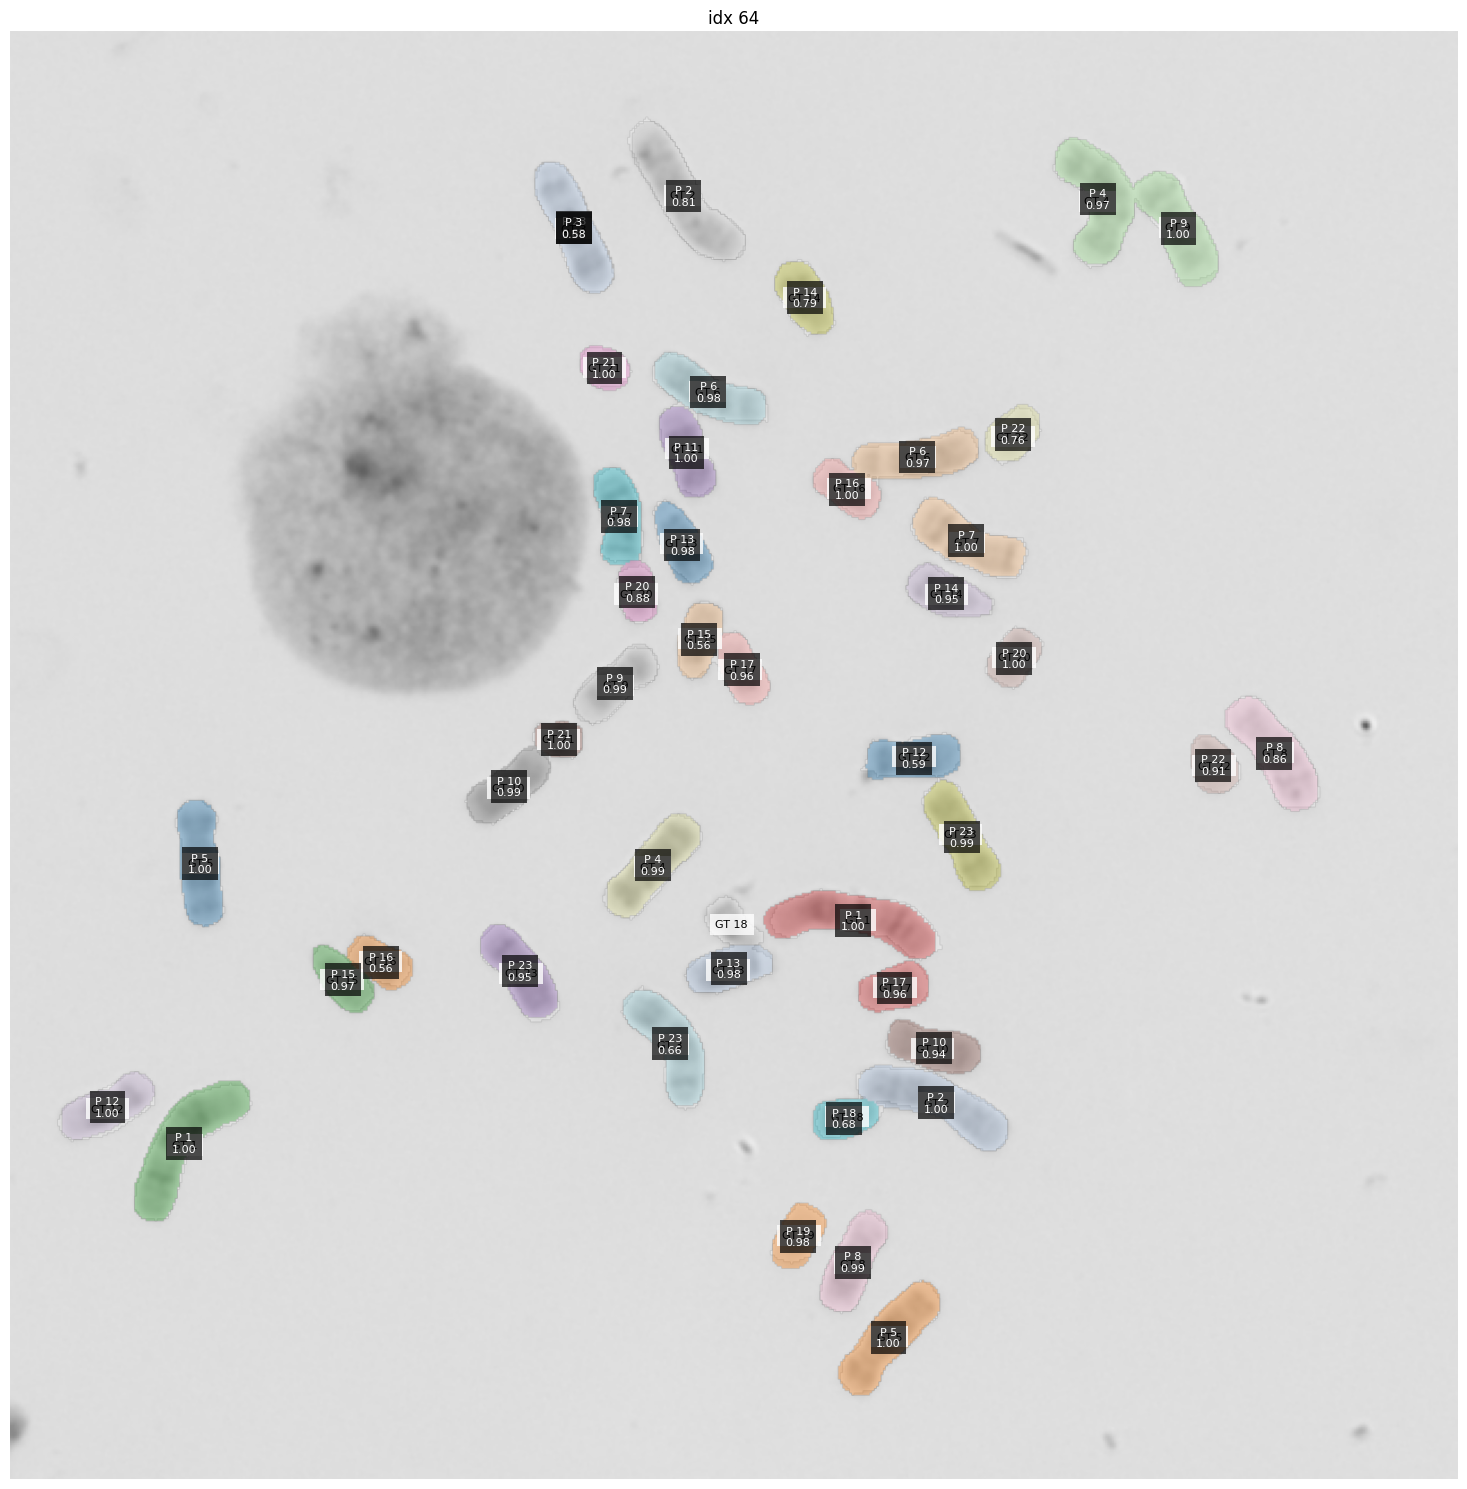

In [6]:
model_B = make_model().to(device)
train_loader_B, val_loader_B = make_loaders_B()
history_B = run_training(
    model_B,
    train_loader_B,
    val_loader_B,
    num_epochs=NUM_EPOCHS,
    experiment_name=EXPERIMENT_NAME + "_B_only",
)

metrics_B_test_Bonly = eval_B_test_metrics(model_B)
print("B-only test metrics:", metrics_B_test_Bonly)

plot_predictions(ds_b_test, model_B, device, n=1, score_thresh=0.5)

In [ ]:
# 2) Train on A train + B train, validate on B val, test on B test, A val (boxes)
model_AB = make_model().to(device)
train_loader_AB, val_loader_AB = make_loaders_AplusB()
history_AB = run_training(
    model_AB,
    train_loader_AB,
    val_loader_AB,
    num_epochs=NUM_EPOCHS,
    experiment_name=EXPERIMENT_NAME + "_AplusB",
)

metrics_B_test_AB = eval_B_test_metrics(model_AB)
print("A+B test metrics:", metrics_B_test_AB)

map50_A_val = eval_A_val_boxes(model_AB)
print("A-val mAP50 (boxes only):", map50_A_val)

plot_predictions(ds_b_test, model_AB, device, n=1, score_thresh=0.5)

2025/12/05 12:03:16 INFO mlflow.tracking.fluent: Experiment with name 'maskrcnn_karyo_AplusB' does not exist. Creating a new experiment.


[epoch 001/040] step 50/1244  loss 2.2460
[epoch 001/040] step 100/1244  loss 2.0851
[epoch 001/040] step 150/1244  loss 1.8460
[epoch 001/040] step 200/1244  loss 1.5627
[epoch 001/040] step 250/1244  loss 1.5699
[epoch 001/040] step 300/1244  loss 1.5668
[epoch 001/040] step 350/1244  loss 1.4049
[epoch 001/040] step 400/1244  loss 1.3132
[epoch 001/040] step 450/1244  loss 1.2764
[epoch 001/040] step 500/1244  loss 1.3599
[epoch 001/040] step 550/1244  loss 1.4240
[epoch 001/040] step 600/1244  loss 1.2260
[epoch 001/040] step 650/1244  loss 1.2933
[epoch 001/040] step 700/1244  loss 1.3069
[epoch 001/040] step 750/1244  loss 1.3395
[epoch 001/040] step 800/1244  loss 1.3629
[epoch 001/040] step 850/1244  loss 1.3668
[epoch 001/040] step 900/1244  loss 1.3195
[epoch 001/040] step 950/1244  loss 1.2712
[epoch 001/040] step 1000/1244  loss 1.0249
[epoch 001/040] step 1050/1244  loss 1.1347
[epoch 001/040] step 1100/1244  loss 1.0111
[epoch 001/040] step 1150/1244  loss 1.1402
[epoch 0